# Telecom Customer Churn Prediction


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay

pd.set_option('display.max_columns', 120)
sns.set(style="whitegrid")

## Load data & quick checks

In [ ]:
df = pd.read_excel("Telco_customer_churn.xlsx")
print("Raw shape:", df.shape)
df.head()

Raw shape: (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [ ]:
rename_map = {
    'CustomerID': 'CustomerID',
    'Tenure Months': 'Tenure',
    'Tenure': 'Tenure',
    'Monthly Charges': 'MonthlyCharges',
    'Monthly Charges ': 'MonthlyCharges',
    'MonthlyCharges': 'MonthlyCharges',
    'Total Charges': 'TotalCharges',
    'TotalCharges': 'TotalCharges',
    'Internet Service': 'InternetService',
    'InternetService': 'InternetService',
    'Payment Method': 'PaymentMethod',
    'PaymentMethod': 'PaymentMethod',
    'Gender': 'Gender',
    'Senior Citizen': 'SeniorCitizen',
    'SeniorCitizen': 'SeniorCitizen',
    'Churn Label': 'Churn',
    'Churn': 'Churn',
    'Count': 'Count',
    'Lat Long': 'LatLong'
}

cols_to_rename = {k:v for k,v in rename_map.items() if k in df.columns}
df = df.rename(columns=cols_to_rename)

print("After rename, columns (sample):")
print(df.columns[:30])

After rename, columns (sample):
Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'LatLong', 'Latitude', 'Longitude', 'Gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'Tenure', 'Phone Service', 'Multiple Lines',
       'InternetService', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'Churn Value'],
      dtype='object')


In [ ]:
print("Shape:", df.shape)
print("\nData types count:\n", df.dtypes.value_counts())
print("\nMissing values (top 15):\n", df.isnull().sum().sort_values(ascending=False).head(15))
print("\nChurn distribution (raw):")
if 'Churn' in df.columns:
    print(df['Churn'].value_counts())
else:
    print("No 'Churn' column found. Please verify the target column name.")

Shape: (7043, 33)

Data types count:
 object     24
int64       6
float64     3
Name: count, dtype: int64

Missing values (top 15):
 Churn Reason         5174
Online Security         0
CLTV                    0
Churn Score             0
Churn Value             0
Churn                   0
TotalCharges            0
MonthlyCharges          0
PaymentMethod           0
Paperless Billing       0
Contract                0
Streaming Movies        0
Streaming TV            0
Tech Support            0
Device Protection       0
dtype: int64

Churn distribution (raw):
Churn
No     5174
Yes    1869
Name: count, dtype: int64


## Data cleaning (small fixes)


In [ ]:
df_clean = df.copy()

if 'TotalCharges' in df_clean.columns:
    df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

drop_candidates = ['CustomerID', 'LatLong', 'Latitude', 'Longitude', 'Country', 'State', 'City', 'Zip Code',
                   'Count', 'Churn Reason', 'Churn Value', 'Churn Score', 'CLTV']
drop_list = [c for c in drop_candidates if c in df_clean.columns]
if drop_list:
    df_clean = df_clean.drop(columns=drop_list)
    print("Dropped:", drop_list)

print("Shape after cleaning:", df_clean.shape)

Dropped: ['CustomerID', 'LatLong', 'Latitude', 'Longitude', 'Country', 'State', 'City', 'Zip Code', 'Count', 'Churn Reason', 'Churn Value', 'Churn Score', 'CLTV']
Shape after cleaning: (7043, 20)


## Exploratory Data Analysis (EDA)

Churn counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn rate (%):
 Churn
No     73.46
Yes    26.54
Name: count, dtype: float64


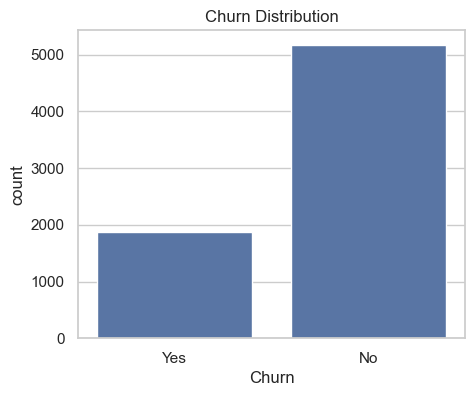

In [ ]:
if 'Churn' in df_clean.columns:
    churn_counts = df_clean['Churn'].value_counts()
    churn_rate = churn_counts / churn_counts.sum() * 100
    print("Churn counts:\n", churn_counts)
    print("\nChurn rate (%):\n", churn_rate.round(2))
    plt.figure(figsize=(5,4))
    sns.countplot(x='Churn', data=df_clean)
    plt.title("Churn Distribution")
    plt.show()
else:
    print("Churn column missing.")

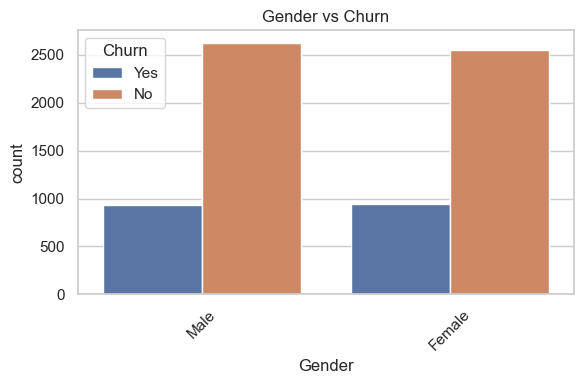

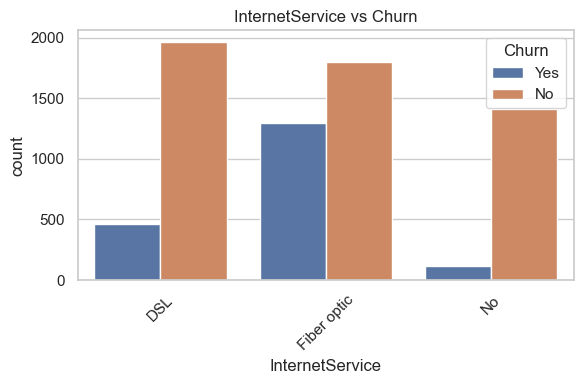

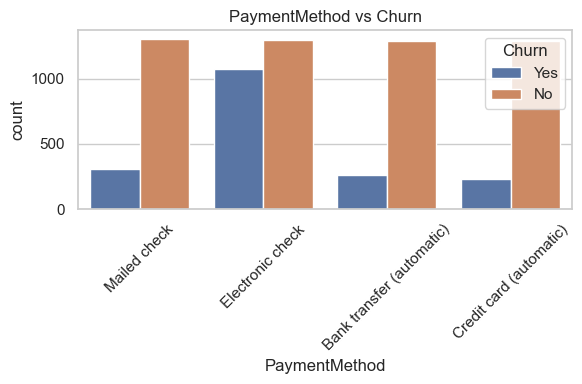

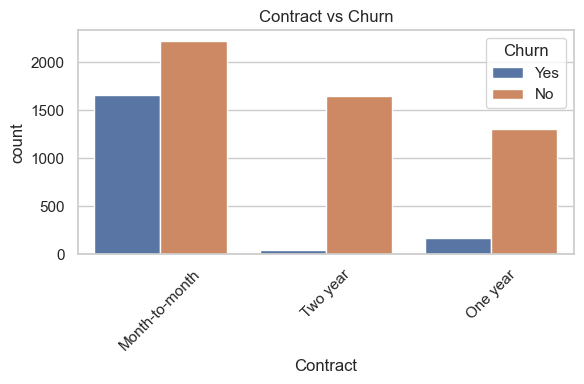

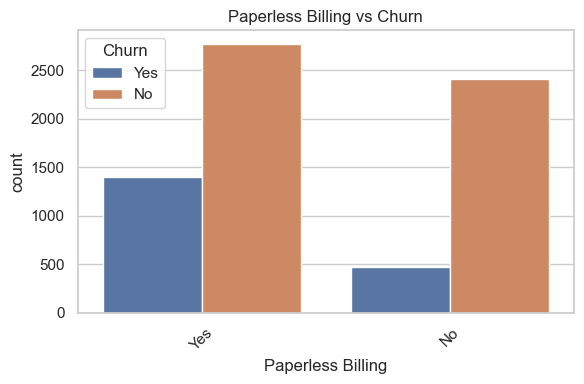

In [ ]:
cats_to_plot = [c for c in ['Gender','InternetService','PaymentMethod','Contract','Paperless Billing','PaperlessBilling'] if c in df_clean.columns]
for col in cats_to_plot:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Churn', data=df_clean)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

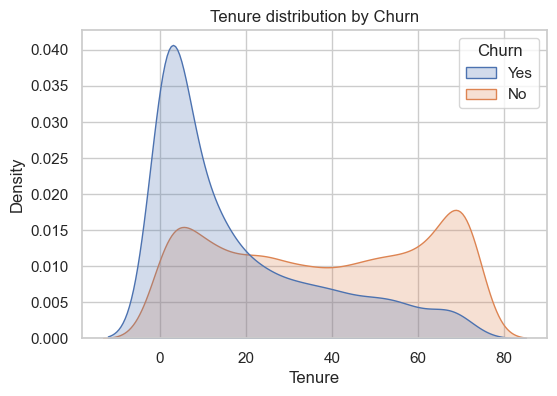

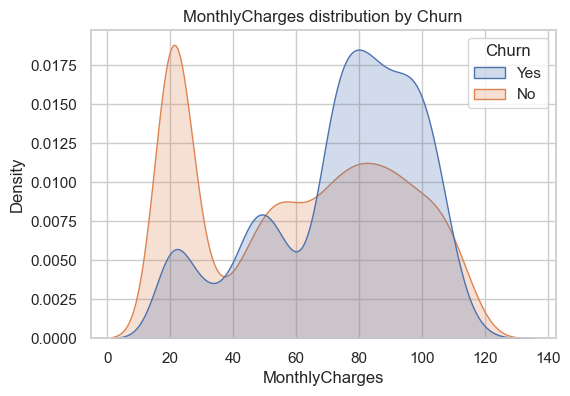

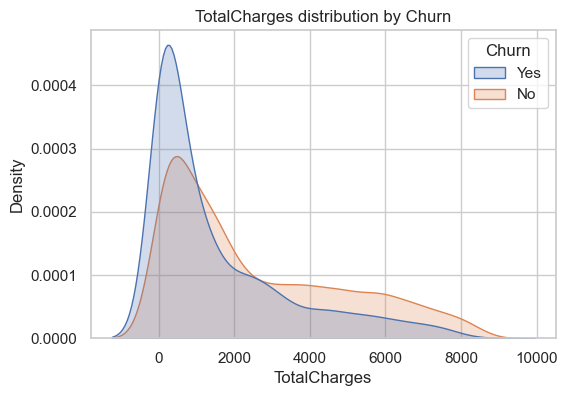

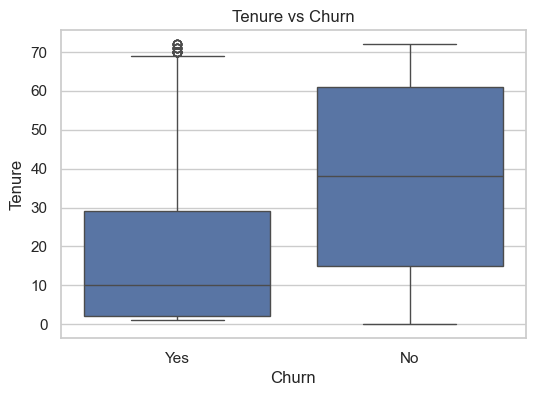

In [ ]:
num_cols = [c for c in ['Tenure','MonthlyCharges','TotalCharges'] if c in df_clean.columns]
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df_clean, x=col, hue='Churn', common_norm=False, fill=True)
    plt.title(f"{col} distribution by Churn")
    plt.show()

if 'Tenure' in df_clean.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y='Tenure', data=df_clean)
    plt.title("Tenure vs Churn")
    plt.show()

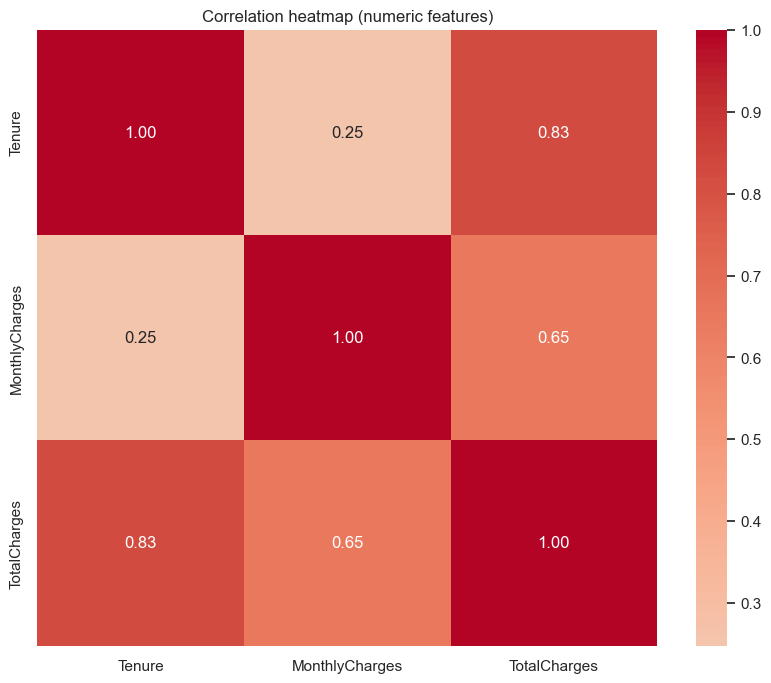

In [ ]:
numeric_for_corr = df_clean.select_dtypes(include=['int64','float64']).columns.tolist()
if numeric_for_corr:
    corr = df_clean[numeric_for_corr].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Correlation heatmap (numeric features)")
    plt.show()
else:
    print("No numeric columns for correlation.")

## Feature selection & preprocessing plan


In [ ]:
if 'Churn' not in df_clean.columns:
    raise KeyError("Target column 'Churn' not found. Check column names.")

y = df_clean['Churn'].map({'Yes':1,'No':0})
X = df_clean.drop(columns=['Churn'])

print("X shape:", X.shape, "y shape:", y.shape)
print("Sample feature columns:", X.columns[:30])

X shape: (7043, 19) y shape: (7043,)
Sample feature columns: Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'Phone Service', 'Multiple Lines', 'InternetService', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [ ]:
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("Categorical columns (sample):", cat_cols[:20])
print("Numeric columns (sample):", num_cols[:20])

Categorical columns (sample): ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'InternetService', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'PaymentMethod']
Numeric columns (sample): ['Tenure', 'MonthlyCharges', 'TotalCharges']


## Modeling: Decision Tree (baseline) & XGBoost 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (5634, 19) Test: (1409, 19)


In [ ]:
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
], remainder='drop')

In [ ]:
dt_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(max_depth=6, random_state=42, class_weight='balanced'))
])

dt_pipeline.fit(X_train, y_train)

y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:,1]

print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree - F1:", f1_score(y_test, y_pred_dt))
print("Decision Tree - ROC AUC:", roc_auc_score(y_test, y_proba_dt))
print("\nClassification report (Decision Tree):\n", classification_report(y_test, y_pred_dt))

Decision Tree - Accuracy: 0.7480482611781405
Decision Tree - F1: 0.6203208556149733
Decision Tree - ROC AUC: 0.834426102456793

Classification report (Decision Tree):
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



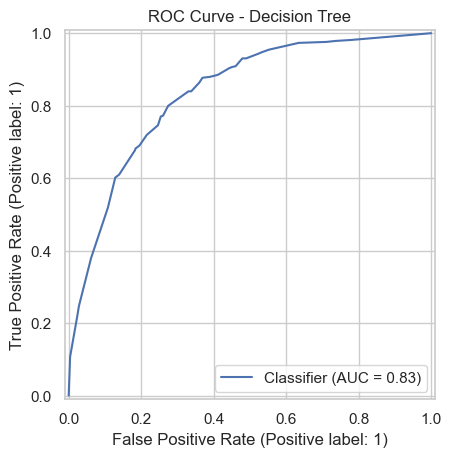

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_proba_dt)
plt.title("ROC Curve - Decision Tree")
plt.show()

In [ ]:
xgb_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:,1]

print("XGBoost - Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost - F1:", f1_score(y_test, y_pred_xgb))
print("XGBoost - ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification report (XGBoost):\n", classification_report(y_test, y_pred_xgb))


XGBoost - Accuracy: 0.7863733144073811
XGBoost - F1: 0.573049645390071
XGBoost - ROC AUC: 0.8369009791004676

Classification report (XGBoost):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.54      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



## Model comparison table


In [ ]:
results = pd.DataFrame({
    "Model": ["Decision Tree", "XGBoost"],
    "Accuracy": [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_xgb)],
    "F1 Score": [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_xgb)],
    "ROC AUC": [roc_auc_score(y_test, y_proba_dt), roc_auc_score(y_test, y_proba_xgb)]
})

results = results.round(4)
results

,Model,Accuracy,F1 Score,ROC AUC
0,Decision Tree,0.7480,0.6203,0.8344
1,XGBoost,0.7864,0.5730,0.8369


## Feature importance (XGBoost)


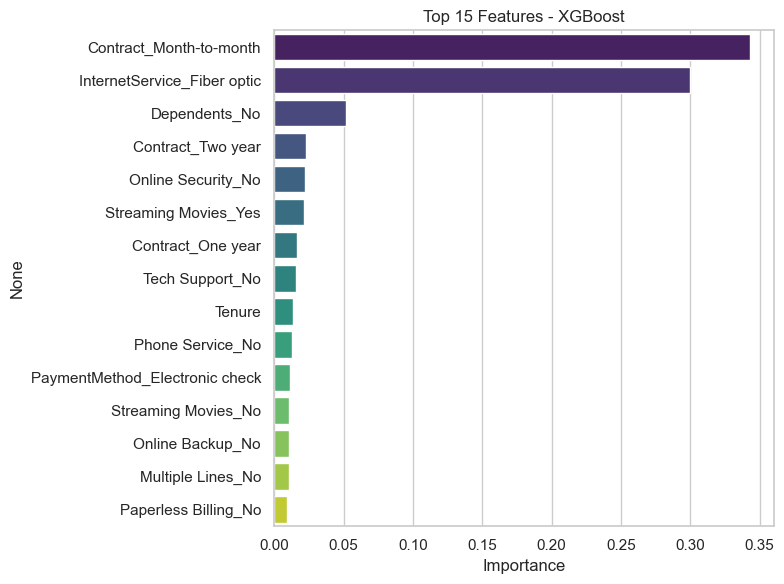

In [ ]:
ohe = xgb_pipeline.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
ohe_feature_names = ohe.get_feature_names_out(cat_cols) if hasattr(ohe, "get_feature_names_out") else ohe.get_feature_names(cat_cols)

all_feature_names = np.r_[ohe_feature_names, num_cols]

xgb_model = xgb_pipeline.named_steps['clf']
importances = xgb_model.feature_importances_

fi = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=fi.head(15), y=fi.head(15).index, palette="viridis")
plt.title("Top 15 Features - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Cross-validated performance 


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_scores = cross_val_score(xgb_pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print("XGBoost CV ROC AUC mean:", xgb_cv_scores.mean().round(4), "std:", xgb_cv_scores.std().round(4))

XGBoost CV ROC AUC mean: 0.8419 std: 0.0111


## Save best model (optional)


In [ ]:
import joblib
joblib.dump(xgb_pipeline, "xgb_churn_pipeline.joblib")
print("Saved xgb_churn_pipeline.joblib")

Saved xgb_churn_pipeline.joblib


## Conclusion & Business Insights

- **Model choice**: XGBoost gave stronger performance than the Decision Tree baseline (see comparison table).  
- **Top churn drivers** (from feature importance): typically: contract type, tenure, monthly charges, internet service, payment method. Inspect the plotted top 15 features for details.  
